In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import torch
import pickle

from tqdm import tqdm
from itertools import combinations 
import numpy as np

In [2]:
df = pd.read_csv("../book_data/book.csv")

In [3]:
df = df.drop(columns=["Unnamed: 0"])

In [4]:
df.shape

(373919, 13)

In [5]:
abs2id = {k:i for i, k in enumerate(set(df.Abstract))}

In [6]:
df['BookId'] = df['Abstract'].apply(lambda x : abs2id[x])

In [7]:
n_uid_reviews = df["User-ID"].value_counts() 
counts = n_uid_reviews.values

In [8]:
big_bins = [len(counts[counts == 1]), len(counts[(1<counts) & (counts <=10)]), 
            len(counts[10<counts])]

<AxesSubplot:>

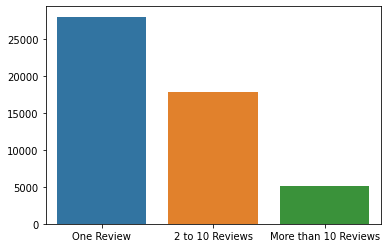

In [9]:
sns.barplot(x=["One Review","2 to 10 Reviews","More than 10 Reviews"],y=big_bins, )

User need to do at least rate two books to do a ranker.

In [10]:
print(df.shape)
df = df[df["User-ID"].isin(n_uid_reviews[(n_uid_reviews >= 2)].index)]
print(df.shape)

(373919, 14)
(345897, 14)


In [11]:
df = df.reset_index(drop=True)

<AxesSubplot:>

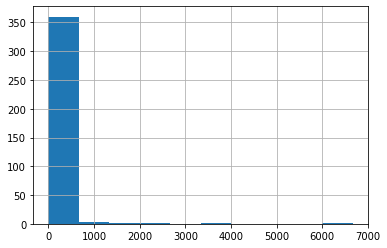

In [12]:
df["User-ID"].value_counts().value_counts().hist()

<AxesSubplot:>

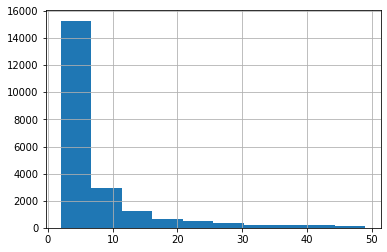

In [13]:
n_uid_reviews = df["User-ID"].value_counts() 
df[df["User-ID"].isin(n_uid_reviews[(n_uid_reviews < 50)].index)]["User-ID"].value_counts().hist()


<AxesSubplot:>

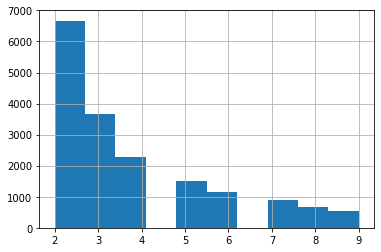

In [14]:
n_uid_reviews = df["User-ID"].value_counts() 
df[df["User-ID"].isin(n_uid_reviews[(n_uid_reviews < 10)].index)]["User-ID"].value_counts().hist()


In [15]:
#We have to create 0-(278854+1) userids for our BERT model

In [16]:
df['User-ID'].max()

278854

In [17]:
x = df['User-ID'].value_counts() > 20
index = x[x].index
df = df[df['User-ID'].isin(index)]

In [18]:
x = df['Abstract'].value_counts() > 20
index = x[x].index
df = df[df['Abstract'].isin(index)]

<AxesSubplot:>

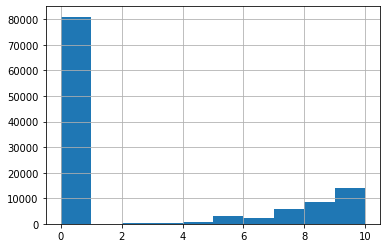

In [19]:
df["Book-Rating"].hist()

In [20]:
pct = 0.1

In [34]:
df_test_list = list()
df_train_list = list()
for user in set(df["User-ID"]):
            
    df_user = df[df["User-ID"] == user]

    indices = list(df_user.index)
    test_indices = np.random.choice(df_user.index,
                                        size=int(len(df_user.index)*pct),
                                        replace=False)
    train_indicies = list(set(indices) - set(test_indices))

    df_test_part = df_user.loc[test_indices]
    df_train_part = df_user.loc[train_indicies]
    
    
    df_test_list.append(df_test_part)
    df_train_list.append(df_train_part)



In [35]:
df_test = pd.concat(df_test_list)
df_train = pd.concat(df_train_list)

In [36]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [37]:
def binIt(v):
    if v <=2:
        return 0 
    elif 2 < v and v <=8:
        return 1 
    else:
        return 2

In [25]:
def binIt(v):
    if v <=2:
        return 0 
    else:
        return 1

In [26]:
#df_train['Book-Rating'] = df_train['Book-Rating'].apply(lambda x: binIt(x))

In [27]:
#df_test['Book-Rating'] = df_test['Book-Rating'].apply(lambda x: binIt(x))

In [38]:
#df_train['Book-Rating'].hist()

In [29]:
#from sklearn.utils import resample


In [30]:
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)


In [31]:

#df_train, balanced_labels = rus.fit_resample(df_train, df_train['Book-Rating'])
#df_test, balanced_labels = rus.fit_resample(df_test, df_test['Book-Rating'])

In [32]:
import pandas as pd
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def getUserDf(df: pd.DataFrame, uid: str)->pd.DataFrame:
    return df[df["User-ID"] == uid]

def getCombinationIxs(df: pd.DataFrame)->np.ndarray:
    ix = np.array([[p[0], p[1]] for p in combinations(df.index, 2)])
    
    #print(ix)
    
    #Remove text combinations with equal rating
    mask = df.loc[ix[:,0]]['Book-Rating'].values != df.loc[ix[:,1]]['Book-Rating'].values
    ix = ix[mask]
    #Shuffle to enusure to get 50/50 likelihood to guess correct
    #ix = shuffle_along_axis(ix, 1)
    return ix

def getRankinLabels(df: pd.DataFrame, ix: np.ndarray)->np.ndarray:
    return df.loc[ix[:,0]]['Book-Rating'].values > df.loc[ix[:,1]]['Book-Rating'].values

def getRankingtext(df: pd.DataFrame, ix: np.ndarray, pos: int)->np.ndarray:
    return df.loc[ix[:,pos]]['Abstract'].values

def getBookCombId(df: pd.DataFrame, ix: np.ndarray):
    book_id1 = df.loc[ix[:,0]]['BookId'].values
    book_id2 = df.loc[ix[:,1]]['BookId'].values
    return np.array([f"{min(bid1, bid2)}_{max(bid1, bid2)}"  for bid1, bid2 in zip (book_id1, book_id2)])

def getBookId(df: pd.DataFrame, ix: np.ndarray, pos: int):
    return df.loc[ix[:,pos]]['BookId'].values
    
    
    
def getRankingUid(df: pd.DataFrame)->pd.DataFrame:
    return df['User-ID'].values

def createRankingDf(labels: np.ndarray, texts1: np.ndarray, texts2: np.ndarray, uids:np.ndarray, 
                    bookid1:np.ndarray, bookid2:np.ndarray)->pd.DataFrame:
    data = [[l, t1, t2, u, bid1, bid2] for l, t1, t2, u,bid1,bid2 in zip(labels, texts1, texts2, 
                                                                         uids, bookid1, bookid2)]
    return pd.DataFrame(data, columns=['label', 'text1', 'text2', 'uid','bid1', 'bid2'])

def creatRankingData(df: pd.DataFrame)->pd.DataFrame:

    label_list, text1_list, text2_list, uid_list, bid1_list, bid2_list = list(), list(), list(), list(), list(), list()
    
    for uid in tqdm(df["User-ID"].unique()):
        #get user df
        df_user = getUserDf(df, uid)
        #print(df_user.shape)
        #get combinations
        ix = getCombinationIxs(df_user)
        
        #Extract values
        label_list.append(getRankinLabels(df_user, ix))        
        text1_list.append(getRankingtext(df_user, ix, 0))
        text2_list.append(getRankingtext(df_user, ix, 1))
        uid_list.append(getRankingUid(df_user))
        bid1_list.append(getBookId(df_user, ix, 0))
        bid2_list.append(getBookId(df_user, ix, 1))
    
    #Combine all users
    labels, texts1, texts2, uids, bid1, bid2 = (np.concatenate(label_list).astype(int), np.concatenate(text1_list), 
                                    np.concatenate(text2_list), np.concatenate(uid_list),
                                    np.concatenate(bid1_list), np.concatenate(bid2_list))
    #Return ranking df
    return createRankingDf(labels, texts1, texts2, uids, bid1, bid2)

    



In [39]:
df_train_ranking = creatRankingData(df_train)

  2%|███                                                                                                                                                                 | 53/2864 [00:00<00:17, 161.27it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
df_ranking = df_train
#df_test = df_test_ranking

In [ ]:
df_ranking

In [ ]:
#Extract data from df
train_uids, train_labels, train_texts1 = list(df_ranking["User-ID"]), list(df_ranking["Book-Rating"]), list(df_ranking["Abstract"])
test_uids, test_labels, test_texts1 = list(df_test["User-ID"]), list(df_test["Book-Rating"]), list(df_test["Abstract"])





In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts1, truncation=True, padding=True)

test_encodings = tokenizer(test_texts1, truncation=True, padding=True)



In [ ]:
class RankingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings1, labels, user_id):
        self.encodings1 = encodings1

        self.labels = labels
        self.user_id = user_id

    def __getitem__(self, idx):
        item = {key + "_1": torch.tensor(val[idx]) for key, val in self.encodings1.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['user_id'] = torch.tensor(self.user_id[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RankingDataset(train_encodings, train_labels, train_uids)
#val_dataset = RankingDataset(valid_encodings1, valid_encodings2, valid_labels, valid_uids)
test_dataset = RankingDataset(test_encodings, test_labels, test_uids)

In [ ]:
pickle.dump(train_dataset, open("../book_data/rankingDataset/train_dataset.pkl", "wb"))
#pickle.dump(val_dataset, open("../book_data/rankingDataset/val_dataset.pkl", "wb"))
pickle.dump(test_dataset, open("../book_data/rankingDataset/test_dataset.pkl", "wb"))